# Causal DAGS for Quasi-Experiments

This page provides an overview of structural causal models for some of the most common quasi-experiments. It takes inspiration from a paper by {cite:t}`steiner2017graphical`, and the books by {cite:t}`cunningham2021causal` and {cite:t}`huntington2021effect`, and readers are encouraged to consult these sources for more details.

In [1]:
import daft
import matplotlib.pyplot as plt

In [2]:
ff = "times new roman"
plt.rcParams["font.family"] = ff

GRID_UNIT = 2.0
DPI = 200
NODE_EC = "none"

Before we take a look at randomized controlled trials (RCTs) and quasi-experiments, let's first consider the concept of confounding. Confounding occurs when a variable (or variables) causally influence both the treatment and the outcome and is very common in observational studies. This can lead to biased estimates of the treatment  effect (the causal effect of $Z \rightarrow Y$). The following causal DAG illustrates the concept of confounding.

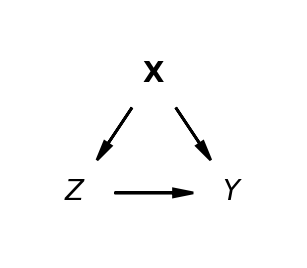

In [3]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_edge("x", "z")

pgm.render();

Randomized controlled trials (RCTs) are considered the gold standard for estimating causal effects. One reason for this is that we (as experimenters) intervene in the system by randomly assigning subjects to treatment groups. This ensures that the treatment is independent of any confounding variables. Importantly, this act of intervention breaks the causal link of the confounders $\mathbf{X}$ upon the treatment $Y$. The following causal DAG illustrates the structure of an RCT.

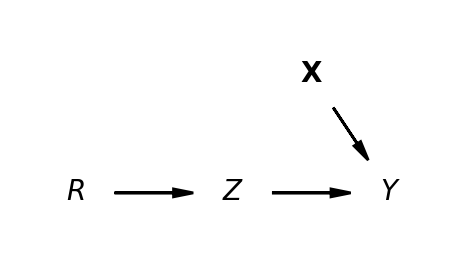

In [4]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("r", "$R$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_node("y", "$Y$", 2, 0)

pgm.add_edge("r", "z")
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")

pgm.render();

The new variable $R$ represents the random assignment of units to the treatment group. So now $Z$ is entirely causally influenced by $R$, and not by any other variables. This means that the treatment effect $Z \rightarrow Y$ can be estimated without bias.

## Instrumental Variables

In quasi-experiments, we cannot randomly assign subjects to treatment groups. So confounders $\mathbf{X}$ will still influence treatment assignment. In the instrumental variable (IV) approach, the causal effect of $Z \rightarrow Y$ is identifiable if we have an IV that causally influences the treatment $Z$ but not the outcome $Y$.

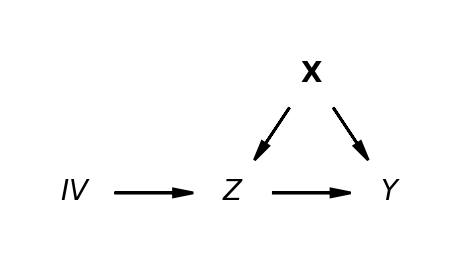

In [5]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("iv", "$IV$", 0, 0)
pgm.add_node("z", "$Z$", 1, 0)
pgm.add_node("y", "$Y$", 2, 0)
pgm.add_node("x", "$\mathbf{X}$", 1.5, 0.75)
pgm.add_edge("iv", "z")
pgm.add_edge("x", "z")
pgm.add_edge("x", "y")
pgm.add_edge("z", "y")

pgm.render();

:::{note}
The assumptions embodied in the DAG are:
1. The IV is independent of the confounders $\mathbf{X}$.
2. The IV causally influences the treatment $Z$.
3. The IV does not causally influence the outcome $Y$, other than through the treatment $Z$.
:::

Readers are referred to {cite:t}`steiner2017graphical` for a more in-depth discussion of the IV approach from the causal DAG and SCM perspective.

:::{note}
TODO: Explain the intuition behind how the IV approach works.
:::

## Interrupted Time Series

A causal DAG for interrupted time series is given in Chapter 17 of {cite:t}`huntington2021effect`, though that book refers to it as [Event Studies](https://theeffectbook.net/ch-EventStudies.html). These kinds of studies are suited to situations where an intervention is made at a given point in time and any causal effect is assumed to have a lasting (not a transient) effect. Here's the causal DAG - note that $\text{time}$ represents all the things changing over time such as the time index as well as time-varying predictor variables.

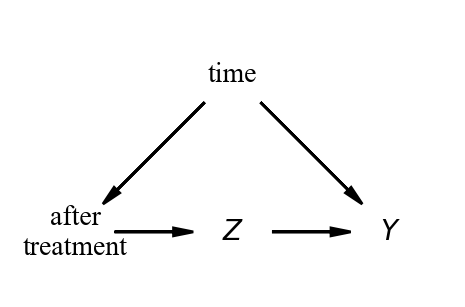

In [6]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

pgm.add_node("a", "after\ntreatment", -1, 0)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)

pgm.add_edge("a", "z")
pgm.add_edge("t", "a")
pgm.add_edge("t", "y")
pgm.add_edge("z", "y")

pgm.render();

What we want to understand is the causal effect of the treatment upon the outcome, $Z \rightarrow Y$. But we have a back door path between $Z$ and $Y$ which will make this hard, $Z \leftarrow \text{after treatment} \leftarrow \text{time} \rightarrow Y$.

The approach taken is to use the pre-treatment data only to create a prediction of what would have happened in the absence of treatment (i.e. the counterfactual). If we can assume that in the absence of the treatment, nothing would have changed, then this counterfactual estimate will be unbiased and we can estimate the treatment effect by comparing the observed (post-treatment) data with the counterfactual.

## Difference in Differences

:::{warning}
This section, including the DAG is a work in progress.
:::

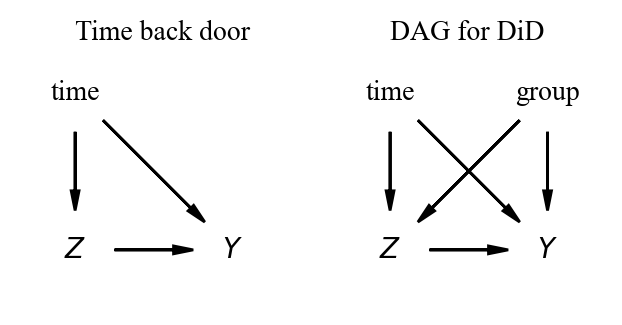

In [7]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

x_offset = 2
# time back door
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_node("t", "time", 0, 1)
# pgm.add_node("g", "group", 1, 1)
pgm.add_edge("t", "z")
pgm.add_edge("t", "y")
# pgm.add_edge("g", "z")
# pgm.add_edge("g", "y")
pgm.add_edge("z", "y")
pgm.add_text(0, 1.3, "Time back door")

# DAG for DiD
pgm.add_node("z2", "$Z$", 0 + x_offset, 0)
pgm.add_node("y2", "$Y$", 1 + x_offset, 0)
pgm.add_node("t2", "time", 0 + x_offset, 1)
pgm.add_node("g2", "group", 1 + x_offset, 1)
pgm.add_edge("t2", "z2")
pgm.add_edge("t2", "y2")
pgm.add_edge("g2", "z2")
pgm.add_edge("g2", "y2")
pgm.add_edge("z2", "y2")
pgm.add_text(x_offset, 1.3, "DAG for DiD")

pgm.render();

Readers are referred to Chapter 18 of {cite:t}`huntington2021effect` for more details.

## Regression Discontinuity
 
The causal graph for the regression discontinuity design is shown below (left). $A$ is a continuous running variable which determines the treatment assignment $A \rightarrow Z$. Assignment is based on a cutoff value $a_c$. The running variable may also influence the outcome $A \rightarrow Y$. The running variable may also be associated with a set of variables $\mathbf{X}$ that influence the outcome, $A - - - - \mathbf{X}$.

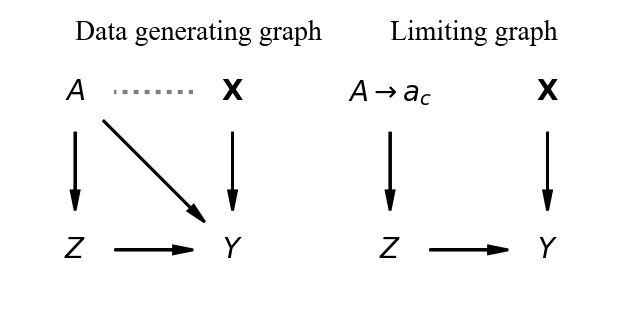

In [8]:
pgm = daft.PGM(dpi=DPI, grid_unit=GRID_UNIT, node_ec=NODE_EC)

# data generating graph
pgm.add_node("a", "$A$", 0, 1)
pgm.add_node("z", "$Z$", 0, 0)
pgm.add_node("x", "$\mathbf{X}$", 1, 1)
pgm.add_node("y", "$Y$", 1, 0)
pgm.add_edge("a", "z")
pgm.add_edge("a", "y")
pgm.add_edge(
    "a",
    "x",
    plot_params={"ec": "grey", "lw": 1.5, "ls": ":", "head_length": 0, "head_width": 0},
)
pgm.add_edge("z", "y")
pgm.add_edge("x", "y")
pgm.add_text(0, 1.3, "Data generating graph")

# limiting graph
x_offset = 2
pgm.add_node("a2", r"$A \rightarrow a_c$", 0 + x_offset, 1)
pgm.add_node("z2", "$Z$", 0 + x_offset, 0)
pgm.add_node("x2", "$\mathbf{X}$", 1 + x_offset, 1)
pgm.add_node("y2", "$Y$", 1 + x_offset, 0)
pgm.add_edge("a2", "z2")
pgm.add_edge("z2", "y2")
pgm.add_edge("x2", "y2")
pgm.add_text(x_offset, 1.3, "Limiting graph")

pgm.render();

The causal effect of $Z \rightarrow Y$ is identified by comparing the outcome for units just above and just below the cutoff value, $A \rightarrow a_c$.

Readers are referred to {cite:t}`steiner2017graphical` and {cite:t}`cunningham2021causal` who discuss limiting graphs in more detail. 

## References
:::{bibliography}
:filter: docname in docnames
:::